In [1]:
import numpy as np
import matplotlib.pyplot as plt
import omero
from omero.gateway import BlitzGateway
import time
from skimage import filters

from tqdm import tqdm
from ipywidgets import Password, Text
from multi_label_pigeon import annotate

# Set up connection to OMERO

In [2]:
global user
global pw
user = Text(description='User:', placeholder='Your Omero Login')

pw = Password(description='Password:', placeholder='Enter password for login')

In [3]:
user

Text(value='', description='User:', placeholder='Your Omero Login')

In [4]:
pw

Password(description='Password:', placeholder='Enter password for login')

In [5]:
def refresh_omero_session(conn):
    if conn==None:
        USERNAME = user.value
        PASSWORD = pw.value
        HOST = "134.76.18.202"
        PORT=   4064

        c = omero.client(host=HOST, port=4064)
        session = c.createSession(USERNAME,PASSWORD)

        print("Connected.")
        conn = BlitzGateway(USERNAME, PASSWORD,host=HOST, port=PORT)
    else:
        #if conn.isConnected():
            #conn.keep_alive()
        
        USERNAME = user.value
        PASSWORD = pw.value
        HOST = "134.76.18.202"
        PORT=   4064

        c = omero.client(host=HOST, port=4064)
        session = c.createSession(USERNAME,PASSWORD)

        print("Connected.")
        conn = BlitzGateway(USERNAME, PASSWORD,host=HOST, port=PORT)
    conn.connect()
    print(conn.isConnected())
    return conn


In [128]:
try: conn
except NameError: conn = None
conn = refresh_omero_session(conn)


Connected.
True


# Monte Carlo Sampling of staining intensity

In [129]:
imageId = 3062
conn.SERVICE_OPTS.setOmeroGroup('-1')
image = conn.getObject("Image", imageId)
group_id = image.getDetails().getGroup().getId()
print("Switched Group to Group of image: ", group_id)
conn.setGroupForSession(group_id)

Switched Group to Group of image:  203


True

In [130]:
pixels = image.getPrimaryPixels()
size_x = image.getSizeX()
size_y = image.getSizeY()
pixels

<_PixelsWrapper id=3062>

define fluorescence channel of interest

In [9]:
channel_of_interest = 1

In [10]:
rand_x = np.random.randint(5,size_x-5,200)
rand_y = np.random.randint(5,size_y-5,200)

In [11]:
pixels_list = []
for id_ in tqdm(np.arange(len(rand_x))):
    pixels_list.append(pixels.getTile(0,theC=channel_of_interest,theT=0,tile=[rand_x[id_],rand_y[id_],5,5]))
    
pixels_list = np.squeeze(np.array(pixels_list))

100%|██████████| 200/200 [01:10<00:00,  2.83it/s]


In [12]:
th_multi_otsu = filters.threshold_multiotsu(pixels_list.flatten())

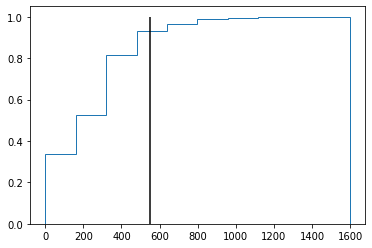

In [13]:
plt.hist(pixels_list.flatten(),cumulative=True,density=True,histtype='step')
plt.vlines(th_multi_otsu[1],0,1)

# Load centroids of nuclei

In [122]:
cods = np.loadtxt("CellposeAllNucleiCentroids.txt",delimiter=",")
x = []
y= []
mean = []
median = []
var = []
skew = []
for p in tqdm(cods):
    x.append(p[0])
    y.append(p[1])
    mean.append(p[2])
    median.append(p[3])
    var.append(p[4])
    skew.append(p[5])
x = np.array(x)
y = np.array(y)
mean = np.array(mean)
median = np.array(median)
var = np.array(var)
skew = np.array(skew)

100%|██████████| 1130/1130 [00:00<00:00, 592371.39it/s]


In [123]:
width=101
height=101
half_width=int(width/2.)
half_height=int(height/2.)
c_max = 4

In [131]:
id_=-1
pixels = image.getPrimaryPixels()
times = []
width=101
height=101
np.random.seed(2000)
rand_i = np.random.permutation(np.arange(len(x)))
tmp_array = np.zeros((width,height))
while var[rand_i[id_]]<700:
    id_ +=1
    print(rand_i[id_]," Mean loading time: "+ str(np.nanmean(times)/4.))
    start = time.time()
    c=1
    #tmp_array[:,:]=pixels.getTile(0,theC=c,theT=0,tile=[x[rand_i[id_]]-half_width,y[rand_i[id_]]-half_height,width,height])
    #mean = np.std(tmp_array[:,:])
    stop = time.time()
    times.append(stop-start)
        #tmp_image = Image.fromarray(np.uint8(tmp_array/np.max(tmp_array)*255.))
tmp_array = np.zeros((width,height,c_max))
for c in range(0,c_max):
    tmp_array[:,:,c]=pixels.getTile(0,theC=c,theT=0,tile=[x[rand_i[id_]]-half_width,y[rand_i[id_]]-half_height,width,height])


<IPython.core.display.Javascript object>


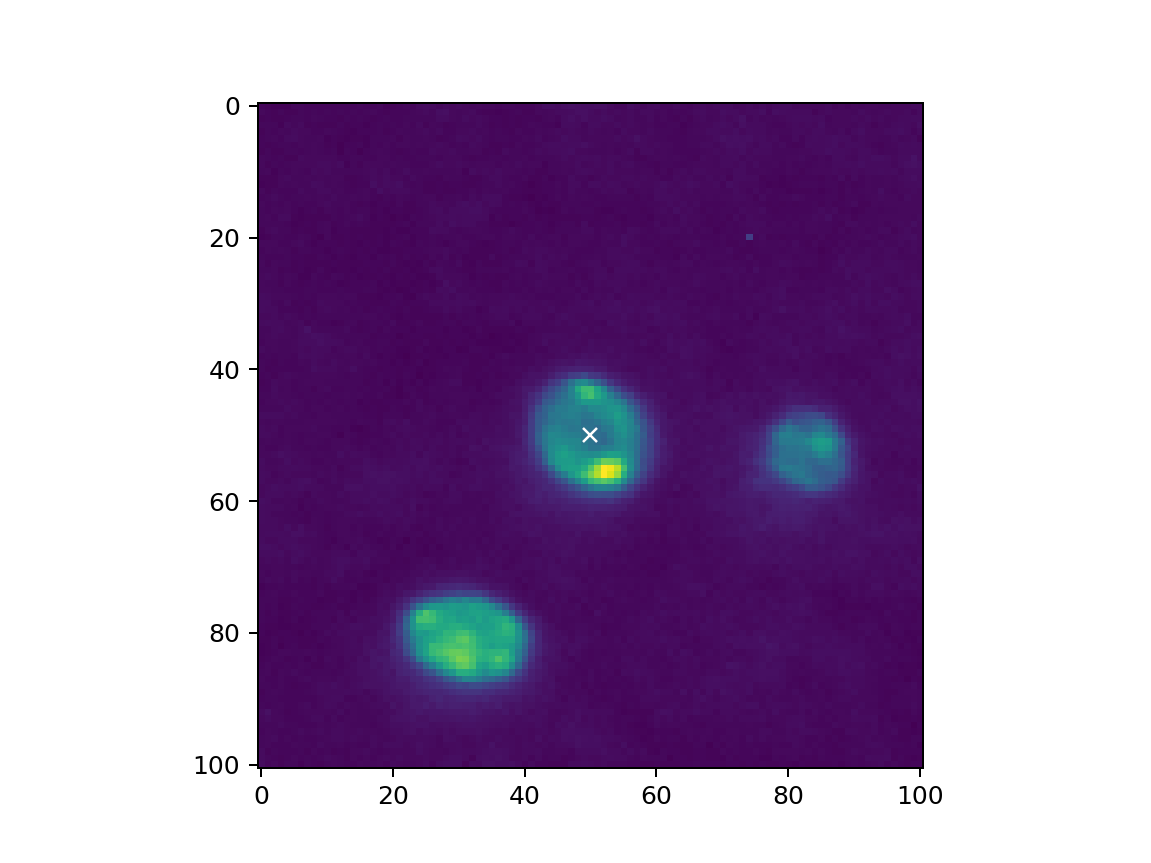

In [132]:
plt.figure(0)
plt.imshow(tmp_array[:,:,0])
plt.plot(half_width,half_height,'wx')
plt.figure(1)
plt.imshow(tmp_array[:,:,1])
plt.plot(half_width,half_height,'wx')
plt.clim([0,max(pixels_list.flatten())])

In [133]:
list_images = np.arange(len(x))

<IPython.core.display.Javascript object>


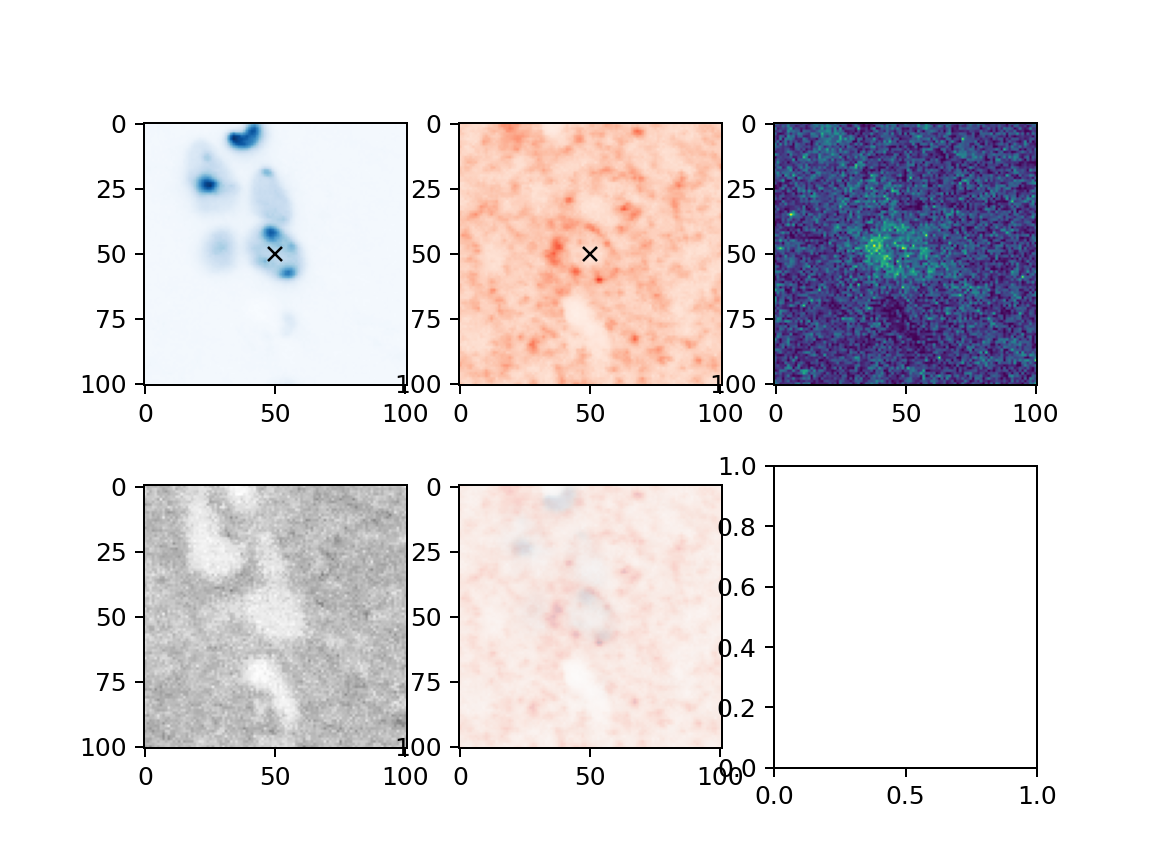

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7febb54ff650>


In [137]:
def show_cell(image_id):
    %matplotlib notebook
    width=101
    height=101
    half_width=int(width/2.)
    half_height=int(height/2.)
    c_max = 4
    image = np.zeros((width,height,c_max))
    for c in range(0,c_max):
        image[:,:,c]=pixels.getTile(0,theC=c,theT=0,tile=[x[image_id]-half_width,y[image_id]-half_height,width,height])

    channel1 = image[:,:,0]
    channel2 = image[:,:,1] 
    channel3 = image[:,:,2]   
    channel4 = image[:,:,3]   
    fig,(ax) = plt.subplots(2,3)
    print(ax)
    ax[0][0].imshow(channel1,cmap="Blues")#, alpha = 0.5)
    ax[0][0].plot(50,50,'kx')
    ax[0][1].imshow(channel2,cmap="Reds",clim=[0,2000])#,alpha = 0.5)
    ax[0][1].plot(50,50,'kx')
    ax[1][0].imshow(channel3,cmap="Greys",alpha = 0.5)
    ax[1][1].imshow(channel1,cmap="Blues", alpha = 0.5)
    ax[1][1].imshow(channel2,cmap="Reds",alpha = 0.5)
    ax[1][1].imshow(channel3,cmap="Greys",alpha = 0.5,clim=[0,2000])
    ax[0][2].imshow(channel4)
    #ax[0][1].set_clim[0,700]
    #ax[1][2].imshow(channel2*ndimage.binary_dilation(channel4,iterations=8),cmap="Reds")
show_cell(list_images[1])

In [138]:
%matplotlib notebook

In [139]:
labeled_data = annotate(list_images[mean>800],["0","1"],display_fn=lambda image: show_cell(image))

HTML(value='0 examples annotated, 23 examples left')

Output()